# Implementation of the MINA model

The model is implemented based on:
* J Moysan, A Apfel, G Corneloup, B Chassignole, Modelling the grain orientation of austenitic stainless steel multipass welds to improve ultrasonic assessment of structural integrity, International Journal of Pressure Vessels and Piping, Volume 80, Issue 2, 2003, Pages 77-85, ISSN 0308-0161, https://doi.org/10.1016/S0308-0161(03)00024-3.
* Cécile Gueudre, Loïc Le Marrec, Joseph Moysan, Bertrand Chassignole, Direct model optimisation for data inversion. Application to ultrasonic characterisation of heterogeneous welds, NDT & E International, Volume 42, Issue 1, 2009, Pages 47-55, ISSN 0963-8695, https://doi.org/10.1016/j.ndteint.2008.07.003.

_Acknowledgements:_
Some advantage was taken from the MATLAB implementation by David Fan (28/09/2010 at Imperial College London).

# First test case 
### (do not change the parameters until well fixed or make a note)
---
D717A from Moysan et al. (2003) - parameters for modelling in Table 2 in the paper.
* Order of passes: [1...m]
* $R_L$: 0.47
* $R_V$: 0.26
* $\theta_B$: 18
* $\theta_C$: 12
* number of layers: 11
* number of passes (see Fig. 2(b)): 1, 2, 2, 2, 2, 3, 3, 4, 4, 4, 4
* electrode diameter (per layer): 1.6, 2.5, 3.2, 4, 5, 5, 5, 5, 4, 4, 4
* $a = 38$ mm
* $b = 4$ mm

* $c = 36$ mm

In [9]:
 not (0 < value < 1)

False

In [26]:
class MINA_weld(object):
    """
    MINA model object collecting parameters of a weld and enabling to calculate and visualise grain orientations.
    
    On initialisation, one should set up weld parameters:
    ---
    remelt_h: horizontal remelting rate
    remelt_v: vertical remelting rate
    theta_b: incline angle (resulting from the electrode tilt) for grains leaning on the chamfer
    theta_c: incline angle (resulting from the electrode tilt) for grains leaning on another pass
    order: order of passes - 'left_to_right': [1...m], 'right_to_left': [m...1], 'mixed': [1,3,...,m,...,4,2]
    number_of_layers: self explanatory
    number_of_passes: number of passes per layer
    electrode_diameter: electrod diameter for each layer
    a: thickness
    b: weld base
    c: length of the top surface
    """
    def __init__(self, weld_parameters, **kwargs):
        for parameter, value in weld_parameters.items():
            setattr(self, parameter, value)
        for key, value in kwargs:
            setattr(self, key, value)
        # check if all parameters are there
        try:
            print('------MINA model setup------')
            print('Horizontal remelting rate: {}'.format(self.remelt_h))
            print('Vertical remelting rate: {}'.format(self.remelt_v))
            print('theta_b and theta_c: {} and {}'.format(self.theta_b, theta_c))
            print('Order of passes: {}'.format(self.order))
            print('Number of layers: {}'.format(self.no_layers))
            print('Number of passes: {}'.format(self.number_of_passes))
            print('Electrode diameter: {}'.format(self.electrode_diameter))
            print('Weld thickness: {}'.format(self.a))
            print('Chamfer base: {}'.format(self.b))
            print('Chamfer top: {}'.format(self.c))
        except AttributeError:
            print("MINA parameters corrupt. Please redefine the model.")

    remelt_h = property(operator.attrgetter('_remelt_h'))
    @remelt_h.setter
    def remelt_h(self, value):
        if not (0 < value < 1): raise Exception("remelt_h parameter should be within the (0, 1) range") 
        self._remelt_h = value
    remelt_v = property(operator.attrgetter('_remelt_v'))
    @remelt_v.setter
    def remelt_v(self, value):
        if not (0 < value < 1): raise Exception("remelt_v parameter should be within the (0, 1) range") 
        self._remelt_v = value
    theta_b = property(operator.attrgetter('_theta_b'))
    @theta_b.setter
    def theta_b(self, value):
        if not (0 < value): raise Exception("theta_b parameter should be within the (0, 1) range") 
        self._theta_b = value
    theta_c = property(operator.attrgetter('_theta_c'))
    @theta_c.setter
    def theta_c(self, value):
        if not (0 < value): raise Exception("theta_c parameter should be within the (0, 1) range") 
        self._theta_c = value
    order = property(operator.attrgetter('_order'))
    @order.setter
    def order(self, value):
        if not (0 < value): raise Exception("order parameter should be 'left_to_right', 'right_to_left', or 'mixed'") 
        self._order = value
    number_of_layers = property(operator.attrgetter('_theta_b'))
    @number_of_layers.setter
    def theta_b(self, value):
        if not (0 < value): raise Exception("theta_b parameter should be within the (0, 1) range") 
        self._theta_b = value

#         if ~(hasattr(self, 'remelt_h') and 0 < remelt_v < 1):
#             print("Error. remelt_h parameter not defined or outside (0, 1) range.")
#         if ~(hasattr(self, 'remelt_v') and 0 < remelt_v < 1):
#             print("Error. remelt_v parameter not defined or outside (0, 1) range.")
#         if ~(hasattr(self, 'a') and a > 0:
#             print("Error. a parameter not defined or negative.")
#         if ~(hasattr(self, 'b') and a > 0:
#             print("Error. b parameter not defined or negative.")
#         if ~(hasattr(self, 'c') and c > 0:
#             print("Error. c parameter not defined or negative.")
        
    
    def define_grid_size(self, size):
        """
        Defines the size of the grid for the MINA model.
        
        Parameters:
        ---
        size: int, grid size in milimetres
        """
        self.grid_size = size
        elements_x = int(np.ceil(self.c/grid_size))
        elements_y = int(np.ceil(self.a/grid_size))
        seeds_x = grid_size/2 + np.arange(0, elements_x*grid_size, grid_size)
        seeds_y = grid_size/2 + np.arange(0, elements_y*grid_size, grid_size)
        self.xx, self.yy = np.meshgrid(seeds_x, seeds_y)
        self.xx += -self.c/2
    
    def get_chamfer_profile(self, y):
        """
        Outputs the profile of the weld chamfer (a simple mapping from the horizontal coordinate(y)
        to the vertical coordinate(z). Used for checking whether a certain point is inside the weld or not.
        
        Parameters:
        ---
        y: float, horizontal coordinate)
        """
        boundary_gradient = 2*a/(c- b)
        f = boundary_gradient*(abs(y) - b/2)
        f *= (f >= 0)
        return f
    

        
    
    
    
        

In [39]:
weld_parameters = dict([('remelt_h', 0)])
weld = MINA_weld(weld_parameters)

weld_parameters.remelt_h = 4

Exception: remelt_h parameter not defined

In [11]:
import operator
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

def recast_features(features_per_layer, passes_layout):
    nested = [counter*[feature] for counter, feature in zip(passes_layout, features_per_layer)]
    recast = np.array([item for sublist in nested for item in sublist])
    return recast

def weld_v(y):
    boundary_gradient = 2*a/(c- b)
    f = boundary_gradient*(abs(y) - b/2)
    f *= (f >= 0)
    return f


In [71]:
# Weld geometrical parameters (dimensions in mm)
a = 38
b = 4
c = 36

# Set up the grid
grid_size = 2
elements_x = int(np.ceil(c/grid_size))
elements_y = int(np.ceil(a/grid_size))
seeds_x = grid_size/2 + np.arange(0, elements_x*grid_size, grid_size)
seeds_y = grid_size/2 + np.arange(0, elements_y*grid_size, grid_size)
xx, yy = np.meshgrid(seeds_x, seeds_y)
xx += -c/2

# Phenomenological parameters for weld creation
theta_b = np.deg2rad(18)
theta_c = np.deg2rad(12)
remelt_v = 0.26
remelt_h = 0.47
h_top_top = 0.3*2
order = 'left_to_right'

# Welding procedure
no_layers = 11
passes_layout = np.array([1] + 4*[2] + 2*[3] + 4*[4])
electrode_d = np.array([1.6] + [2.5] + [3.2] + [4] + [5]*4 + [4]*3)

In [72]:
# Calculate the thickness of each layer
# Calculate the proportionality constant
if order != 'left_to_right':
    print("Only 'left_to_right' order of passes is now implmementd.")
beta = (a - h_top_top)/((1 - remelt_v)*electrode_d.sum() + remelt_v*electrode_d[-1])
pass_width = (b + (c - b)/a*(beta*((1 - remelt_v)*np.cumsum(electrode_d) + remelt_v*electrode_d)))/\
                (passes_layout*(1 - remelt_h) + remelt_h)
layer_thickness = beta*electrode_d
layer_width = pass_width*((1 - remelt_h)*passes_layout + remelt_h)

# Calculate centres of each pass
pass_y_abscissa = np.cumsum(layer_thickness*np.array([1] + 
                                                     [1 - remelt_v]*(len(layer_thickness) - 1)))
pass_x_ordinates = np.cumsum(pass_width.reshape(-1, 1)*\
                             np.array([0.5] + 
                                      [1 - remelt_h]*passes_layout.max()).reshape(1, -1), 
                            axis=1)

pass_x_center = []
pass_y_center = []
passes_in_layer = dict()
pass_counter = 0
pass_corrections = []
for i, passes in enumerate(list(passes_layout)):
    passes_in_layer.update({i: (list(range(pass_counter, pass_counter + passes)))})
    this_pass_corrections = (int(passes) > 1)*[-theta_b] + \
                            [-theta_c]*(int(passes) - 2)*(int(passes) > 2) + [0]
    pass_corrections.extend(this_pass_corrections)
    pass_counter += passes
    pass_y_center.extend([pass_y_abscissa[i]]*passes)
    pass_x_center.extend(list(pass_x_ordinates[i, :passes] - layer_width[i]/2))

    # Set up a look-up table giving layer number for a given pass
layer_of_pass = dict()
for k, v in passes_in_layer.items():
    for this_pass in v:
        if this_pass not in layer_of_pass.keys():
            layer_of_pass.update({this_pass: k})

point_b = np.c_[np.array(pass_x_center), np.array(pass_y_center)]
point_o = np.copy(point_b)
point_o[:, 1] += -recast_features(layer_thickness, passes_layout)
point_c = point_b + np.array([[0, h_top_top]])
point_d = np.copy(point_b)
point_d[:, 1] +=  recast_features(pass_width, passes_layout)/2

In [73]:
def bottom_parabola(x, pass_no):
    return layer_thickness[layer_of_pass[pass_no]]/(pass_width[layer_of_pass[pass_no]]/2)**2*\
            (x - point_o[pass_no, 0])**2 + point_o[pass_no, 1]

def top_parabola(x, pass_no):
    return -h_top_top/(pass_width[layer_of_pass[pass_no]]/2)**2*\
            (x - point_c[pass_no, 0])**2 + point_c[pass_no, 1]

pass_assignments = -99 + np.zeros(xx.shape)
alpha_g = np.nan*np.zeros(xx.shape)
for this_pass in range(len(point_c)):
    points_in = (np.where((yy > bottom_parabola(xx, this_pass)) & (yy < top_parabola(xx, this_pass))))
    pass_assignments[points_in[0], points_in[1]] = this_pass
    alpha_g[points_in[0], points_in[1]] = np.arctan((xx[points_in[0], points_in[1]] - point_d[this_pass, 0])/\
        (point_d[this_pass, 1] - yy[points_in[0], points_in[1]])) + pass_corrections[this_pass]

In [75]:
xx[yy < weld_v(xx)] = np.nan
yy[yy < weld_v(xx)] = np.nan

in_weld = np.where(~np.isnan(xx[0, :]))[0]
final_alpha = np.copy(alpha_g)
n = 10
for i in range(1, final_alpha.shape[1] + 1):
    new_starters = np.where(np.isnan(final_alpha[i - 1, :]))[0]
    old_grains = np.where(~np.isnan(final_alpha[i - 1, :]))[0]
    final_alpha[i, new_starters]= alpha_g[i, new_starters]
    previous_alpha = final_alpha[i - 1, old_grains]
    for iteration in range(n):
        angle_difference = previous_alpha - alpha_g[i, old_grains]
        t = np.cos(angle_difference)
        t[angle_difference >= np.pi/2] = 0
        this_alpha = t*previous_alpha + (1 - t)*alpha_g[i, old_grains]
        previous_alpha = this_alpha
    final_alpha[i, old_grains] = np.copy(this_alpha)


/home/michal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater_equal
  del sys.path[0]
/home/michal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/home/michal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


<IPython.core.display.Javascript object>


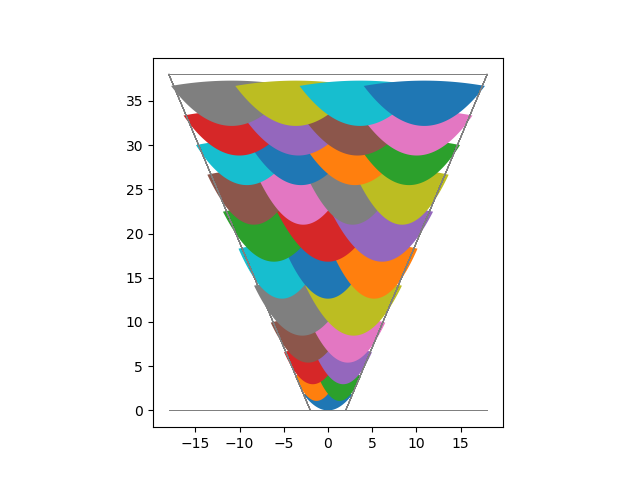

In [76]:
fig, ax = plt.subplots()
for i in range(len(point_b)):
    local_x = np.linspace(point_b[i, 0] - pass_width[layer_of_pass[i]]/2, point_b[i, 0] + pass_width[layer_of_pass[i]]/2, 100)
    y_top = top_parabola(local_x, i)
    y_bot = bottom_parabola(local_x, i)
    ax.fill_between(local_x, y_bot, y_top, alpha=1)
    ax.set_aspect('equal')
#     ax.plot(local_x, y_top, c='lightgray')
#     ax.plot(local_x, y_bot, c='lightgray')
#     ax.plot(point_b[i, 0], point_b[i, 1], 'o',ms=4, c='black')
#     ax.plot(point_o[i, 0], point_o[i, 1], '^',ms=4, c='black')
    ax.plot([-b/2, -c/2], [0, a], lw=0.5, c='gray')
    ax.plot([b/2, c/2], [0, a], lw=0.5, c='gray')
    ax.plot([-c/2, c/2], [0, 0], lw=0.5, c='gray')
    ax.plot([-c/2, c/2], [a, a], lw=0.5, c='gray')


<IPython.core.display.Javascript object>


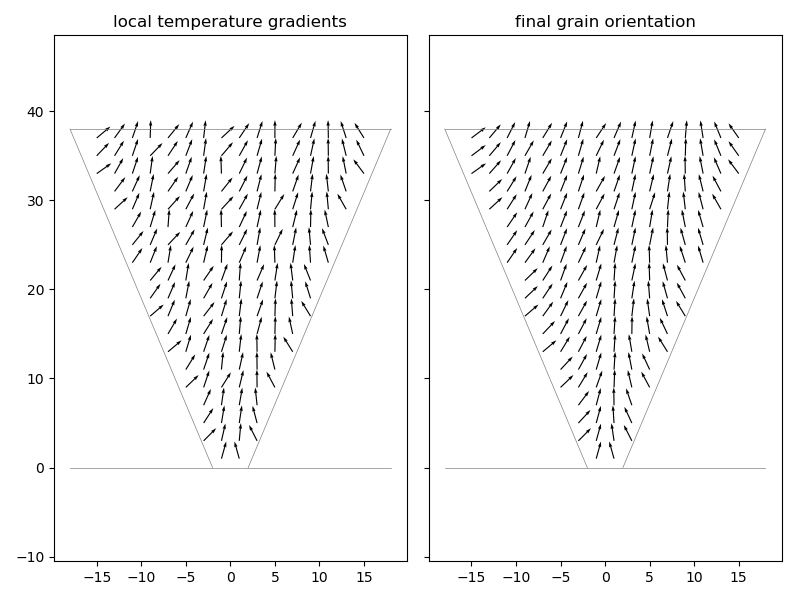

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 6))
ax1.quiver(xx, yy, np.cos(alpha_g + np.pi/2), np.sin(alpha_g + np.pi/2), units='xy', scale=0.5)
ax1.set_aspect('equal')
ax1.set_title('local temperature gradients')
ax1.plot([-b/2, -c/2], [0, a], lw=0.5, c='gray')
ax1.plot([b/2, c/2], [0, a], lw=0.5, c='gray')
ax1.plot([-c/2, c/2], [0, 0], lw=0.5, c='gray')
ax1.plot([-c/2, c/2], [a, a], lw=0.5, c='gray')

ax2.quiver(xx, yy, np.cos(final_alpha + np.pi/2), np.sin(final_alpha + np.pi/2), units='xy', scale=0.5)
ax2.set_aspect('equal')
ax2.set_title('final grain orientation')
ax2.plot([-b/2, -c/2], [0, a], lw=0.5, c='gray')
ax2.plot([b/2, c/2], [0, a], lw=0.5, c='gray')
ax2.plot([-c/2, c/2], [0, 0], lw=0.5, c='gray')
ax2.plot([-c/2, c/2], [a, a], lw=0.5, c='gray')
plt.tight_layout()